# UNet Model
### This section provides an overview and initial setup for implementing a U-Net model, a type of convolutional neural network used for image segmentation tasks.

## Libraries Required

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from torch import nn
import os
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, ToTensor
from PIL import Image
from torchvision import transforms
import requests
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt



# Dataset


### This section outlines the dataset - This will load, preprocess and augmentation.

## Set Root Directory (Where data is located)


In [127]:
root_dir = 'CBSD68'

## Dataset Class 


#### The dataset class is defined. To add more variation/ increase the training data size, transformations were applied to the images. 
#### However, applying the transformations to the noisy images also transforms the noise on the image, confusing the model. Therefore, translations are directly applied to the original_png images and then adding AWGN.
#### This approach ensures that noise is consistently applied across the transformed images which will prevent the model confusion caused by varying noise patterns.

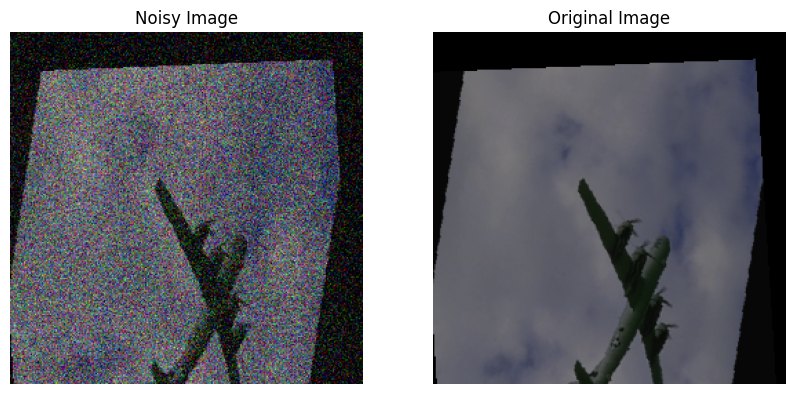

In [128]:
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

class AdjustedDenoisingDataset(Dataset):
    #initialise Dataset paramaters and paths
    def __init__(self, root_dir, noise_std, transform=None, training=True):
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.noise_std = noise_std  
        #if training is true, use first 56 images, else use last 12
        self.image_ids = [f"{i:04d}.png" for i in (range(56) if training else range(56, 68))]
    # returns number of images in dataset
    def __len__(self):
        return len(self.image_ids)
    # returns noisy image and original image
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        original_img_path = os.path.join(self.root_dir, 'original_png', image_id)  
        original_image = Image.open(original_img_path).convert("RGB")
        #applies transform to original png image
        if self.transform:
            original_image = self.transform(original_image)
        #applies noise to original png image
        original_image_np = np.array(original_image)
        standard_deviation = random.uniform(0, self.noise_std)

        noise = np.random.normal(0, standard_deviation, original_image_np.shape).astype(np.float32)
        noisy_image_np = original_image_np + noise
        noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)
        
        noisy_image = Image.fromarray(noisy_image_np)
        #convert image to tensor
        noisy_image_tensor = transforms.ToTensor()(noisy_image)
        original_image_tensor = transforms.ToTensor()(original_image)
        
        return noisy_image_tensor, original_image_tensor

# transformations applied to original image to create a varied traiining dataset
transformations = transforms.Compose([
    transforms.RandomRotation((0, 360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.Resize((256, 256))
])

noise_std = 50  # Standard deviation of the Gaussian noise

# training and test datasets created with the same noise standard deviation and transformations 
training_dataset = AdjustedDenoisingDataset(root_dir, noise_std=noise_std, transform=transformations, training=True)
test_dataset = AdjustedDenoisingDataset(root_dir, noise_std=noise_std, transform=transformations, training=False)

# gets the first image from the training dataset
noisy_image, original_image = training_dataset[0]

# Converts tensors to PIL images
noisy_image_pil = transforms.ToPILImage()(noisy_image)
original_image_pil = transforms.ToPILImage()(original_image)

# plot 1st PIL images to test
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(noisy_image_pil)
axes[0].set_title('Noisy Image')
axes[0].axis('off')
axes[1].imshow(original_image_pil)
axes[1].set_title('Original Image')
axes[1].axis('off')

plt.show()




# UNet Convolutional Neural Network Architecture 

### Defines the U-Net model architecture: encoding, decoding, and bottleneck layers to denoise images.

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#UNet model reference
"""
@misc{labml,
 author = {Varuna Jayasiri, Nipun Wijerathne},
 title = {labml.ai Annotated Paper Implementations},
 year = {2020},
 url = {https://nn.labml.ai/},
}
"""

# Define U-Net model architecture with: convolutional blocks, downscaling, upscaling, and output layers
# Reference: https://nn.labml.ai/annotated_deep_learning_paper/implementations/2020/07/22/u_net.html


# double convolution layer is defined 
class DoubleConv(nn.Module):
# Double convolutional layer with batch normalization and ReLU activation
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), # convolutional layer
            nn.BatchNorm2d(mid_channels), # batch normalization
            nn.ReLU(inplace=True), # ReLU activation 
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1), # convolutional layer
            nn.BatchNorm2d(out_channels), # batch normalization
            nn.ReLU(inplace=True) # ReLU activation
        )
    # forward propogation through double convolution layer
    def forward(self, x):
        return self.double_conv(x)


# Downscaling layer is defined
class Down(nn.Module):
# downscaling with maxpooling and double convolution
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), #pooling with kernal size 2 for downscaling 
            DoubleConv(in_channels, out_channels)
        )
    # forward propogation through downscaling layer
    def forward(self, x):
        return self.maxpool_conv(x)
    

# Upscaling layer is defined
class Up(nn.Module):
# upscaling layer with bilinear interpolation
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

# forward propogation through upscaling layer
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)
    
# output convolutional layer is defined
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

# forward propogation through output convolutional layer
    def forward(self, x):
        return self.conv(x)


# U-Net model is defined
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the U-Net model with 3 input channels and 3 output channels
model = UNet(n_channels=3, n_classes=3).to(device) 

# Loss Function Calculation - SSIM

### Defines the SSIM loss function, to measure the similarity between the original and denoised images. It comapres changes in texture, contrast, and luminance to preserve the high detail perceptual and structural aspects of the image.


In [131]:
import torch
import torch.nn.functional as F

def gaussian_window(size, sigma):
    # Generates a 2D Gaussian window for SSIM calculation
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2 # Center window at 0

    g = coords**2
    g = (-g / (2 * sigma**2)).exp() # Apply Gaussian formula to tensor

    g /= g.sum() # Normalise the window
    return g.outer(g)

def ssim(img1, img2, window_size=11, window_sigma=1.5, size_average=True, channel=3):
    # Calculate SSIM between two images, by averaging over all pixels

    L = 1  
    C1 = (0.01 * L)**2
    C2 = (0.03 * L)**2
    # Gaussian window based on size and sigma
    window = gaussian_window(window_size, window_sigma).to(img1.device)
    window = window.expand(channel, 1, window_size, window_size)
    
    # img1 and img2 mean
    mean_values_1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mean_values_2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    # Squared mean values
    mean_values_1_sq = mean_values_1.pow(2)
    mean_values_2_sq = mean_values_2.pow(2)
    mean_values_1_mean_values_2 = mean_values_1 * mean_values_2
    
    # img1 and img2 variance and covariance
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mean_values_1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mean_values_2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mean_values_1_mean_values_2
    
    ''' SSIM formula '''
    ssim_map = ((2 * mean_values_1_mean_values_2 + C1) * (2 * sigma12 + C2)) / ((mean_values_1_sq + mean_values_2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    # Average SSIM over all pixels (if size_average=True) 
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(torch.nn.Module):
    # Class for SSIM loss to integrate SSIM as loss function
    def __init__(self, window_size=11, window_sigma=1.5, size_average=True, channel=3):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.window_sigma = window_sigma
        self.size_average = size_average
        self.channel = channel
        
    def forward(self, img1, img2):
        # 1 - SSIM to minimize distance (loss)
        return 1 - ssim(img1, img2, self.window_size, self.window_sigma, self.size_average, self.channel)
    


# TRAIN MODEL

training

In [133]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle

#hyperparameters
batch_size = 8
n_epochs = 1001
lr = 0.0001

#loads training dataset
data_loader = DataLoader(training_dataset, batch_size, shuffle=True)

# Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimiser function and loss function
optimiser = optim.Adam(model.parameters(), lr)
criterion = SSIMLoss()


# Train the model
def train_model(model, data_loader, optimiser, criterion, n_epochs):
    losses = []
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        # Iterate over dataset
        for batch in data_loader:
            noisy_imgs, original_imgs = batch
            noisy_imgs, original_imgs = Variable(noisy_imgs.to(device)), Variable(original_imgs.to(device))
            
            optimiser.zero_grad()
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, original_imgs)
            loss.backward()
            optimiser.step()
            
            running_loss += loss.item()
            losses.append(loss.item())
        
        epoch_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss}")
    print('Finished Training')
    return losses

losses = train_model(model, data_loader, optimiser, criterion, n_epochs)


save_data_dir = 'data'

# Create 'data' directory if does not exist
if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)

# Set filename
pickle_file = 'data/losses'
pickle_file = pickle_file + str(len(os.listdir(save_data_dir))) + "_epochs_" + str({n_epochs}) + ".pkl"

# Pickle the losses variable to plot later
with open(pickle_file, 'wb') as f:
    pickle.dump(losses, f)

print(f"Losses pickled and saved to {pickle_file}")


Epoch 1/1001, Loss: 0.4755057011331831
Epoch 2/1001, Loss: 0.4444641556058611
Epoch 3/1001, Loss: 0.4492564456803458
Epoch 4/1001, Loss: 0.44550890581948416
Epoch 5/1001, Loss: 0.4475159134183611
Epoch 6/1001, Loss: 0.4016242282731192
Epoch 7/1001, Loss: 0.4147695132664272
Epoch 8/1001, Loss: 0.40106663533619474
Epoch 9/1001, Loss: 0.4133637717791966
Epoch 10/1001, Loss: 0.40963118416922434
Epoch 11/1001, Loss: 0.3834911584854126
Epoch 12/1001, Loss: 0.35608948128564016
Epoch 13/1001, Loss: 0.3603001577513559
Epoch 14/1001, Loss: 0.34637801136289326
Epoch 15/1001, Loss: 0.3334640690258571
Epoch 16/1001, Loss: 0.3318331922803606
Epoch 17/1001, Loss: 0.30594678436006817
Epoch 18/1001, Loss: 0.3159085937908718
Epoch 19/1001, Loss: 0.3085851584162031
Epoch 20/1001, Loss: 0.3100933177130563
Epoch 21/1001, Loss: 0.30234581232070923
Epoch 22/1001, Loss: 0.31111901147024973
Epoch 23/1001, Loss: 0.3239725572722299
Epoch 24/1001, Loss: 0.3016243577003479
Epoch 25/1001, Loss: 0.29535010882786344


KeyboardInterrupt: 

# save model

In [88]:
import os

save_dir = 'models'

# Create 'models' directory if does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
n_epochs = len(losses)

# Set filename
filename = "trained_model_{n_epochs}"
filename = filename + str(len(os.listdir(save_dir))) + '.pth'

# Save the model to the 'models' directory
print(torch.save(model.state_dict(), os.path.join(save_dir, filename)))


None


## Load Model

In [107]:
# Load model
import os

# List all files in 'models' folder
saved_models_folder = 'models'
matches = []
for root, dirnames, filenames in os.walk(saved_models_folder):
    for filename in filter(lambda name: name.endswith('.pth'), filenames):
        matches.append(os.path.join(root, filename))

# Print/list all model files in 'models' folder
print("Available model files:")
for i, file in enumerate(matches):
    print(f"{i+1}. {file}")

# User selects model file to load
selected_index = int(input("Enter the index of the model file to load: ")) - 1

# Load the user selected model file
selected_model_file = matches[selected_index]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(selected_model_file, map_location=device))
model.to(device)


Available model files:
1. models/1000_epoch_model.pth
2. models/trained_model2.pth
3. models/trained_model3.pth
4. models/trained_model1.pth
5. models/trained_model0.pth
6. models/trained_model_{n_epochs}5.pth


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

# plot

Available data pkl files:
1: losses4.pkl
2: losses5_epochs_{10}.pkl
3: losses4_epochs_{1}.pkl
4: losses2.pkl
5: losses3.pkl
6: losses.pkl


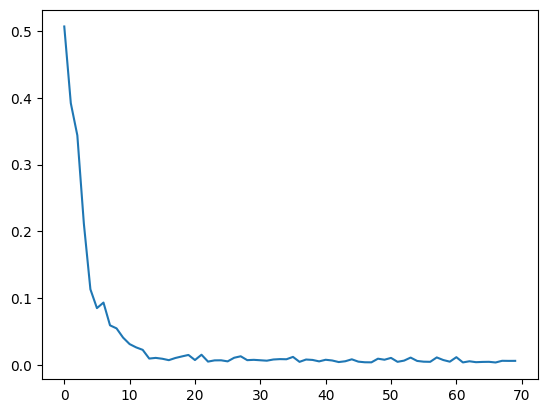

In [90]:
import pickle
import matplotlib.pyplot as plt
import os
# Get all pkl files in 'data' folder
data_folder = 'data'
files = os.listdir(data_folder)
pkl_files = [file for file in files if file.endswith('.pkl')]

# Print/list all pkl files in 'data' folder
print("Available data pkl files:")
for i, file in enumerate(pkl_files):
    print(f"{i + 1}: {file}")  

# User selects pkl file to load
selected_pkl_index = int(input("Enter the index of the model file to load: ")) - 1
selected_model_file = pkl_files[selected_pkl_index]  # Fixed variable name

# Load user selected pkl file
with open(os.path.join(data_folder, selected_model_file), 'rb') as file:
    losses = pickle.load(file)

# Plot losses values
plt.plot(losses)
# plt.yscale('log')
plt.show()  # Added to explicitly show the plot


## test data 
#### (compare loss function values)

In [44]:
# load test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set model to evaluation mode
model.eval()  


criterion = SSIMLoss()
#old loss function => criterion = nn.MSELoss()

# run test dataset through evalutation mode and calculate loss
test_losses = []
with torch.no_grad():
    for batch in test_loader:
        noisy_img, original_img = batch
        noisy_img, original_img = noisy_img.to(device), original_img.to(device)
        
        output = model(noisy_img)
        loss = criterion(output, original_img)
        test_losses.append(loss.item())

average_loss = sum(test_losses) / len(test_losses)
print(f"Average loss on test dataset: {average_loss}")


Average loss on test dataset: 0.15053224563598633


## test image against model

Loss value (SSIM): 0.5925360918045044


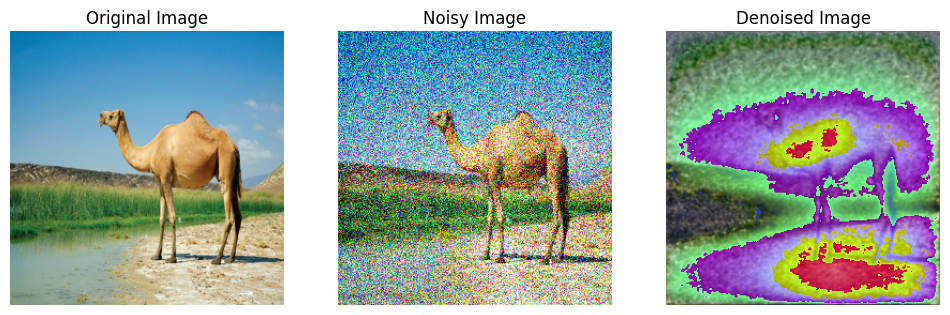

In [109]:
import requests
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
import matplotlib.pyplot as plt

# Set device to use GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = SSIMLoss()

# Convert tensor to PIL Image 
def tensor_to_pil(tensor):
    unloader = transforms.ToPILImage()  # Convert tensor to PIL Image
    image = tensor.cpu().clone()  
    image = image.squeeze(0)     
    image = unloader(image)
    return image

# Fetch user entered image 
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 
    return img

# Add noise to user entered image
def addnoise(image, noise_level):
    original_image_np = np.array(image)
    # Scale the noise level to a standard deviation. Example: max std deviation could be 64 (25% of 255)
    max_std_deviation = 64
    standard_deviation = (noise_level / 100.0) * max_std_deviation

    noise = np.random.normal(0, standard_deviation, original_image_np.shape).astype(np.float32)
    noisy_image_np = original_image_np + noise
    noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)
    
    noisy_image = Image.fromarray(noisy_image_np)
    return noisy_image


# Denoise user entered image using trained model
def denoise_image(image):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    input_tensor = preprocess(image).to(device).unsqueeze(0)  
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze(0)  #

# Process user entered image
def process_image(image_url, noise_level):
    original_image = fetch_image(image_url)
    original_image = original_image.resize((256, 256))
    noisy_image = addnoise(original_image, noise_level)
    
    # Convert noisy image to tensor
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    original_image_tensor = preprocess(original_image).to(device)

    denoised_image_tensor = denoise_image(noisy_image)
    denoised_image = tensor_to_pil(denoised_image_tensor)

    # loss = F.mse_loss(denoised_image_tensor, original_image_tensor)
    loss = criterion(denoised_image_tensor, original_image_tensor)

    print(f"Loss value (SSIM): {loss.item()}")

    # plot images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis('off')

    plt.show()
    

image_url = input("Enter the URL of the image to denoise: \n")
noise_level = float(input("Enter the noise level (0-100): \n"))
process_image(image_url, noise_level)